# 基于Faster RCNN的枪支检测(PaddleX快速上手版)

# 项目简介：
在平日的生活娱乐场所中存在着诸多安全隐患，其中出售违规枪支、手持枪支抢劫的犯罪情形危害性极大。通过计算机视觉的方法对交通运输、社交娱乐等重点活动场所进行监控，识别出可能存在出售违规枪支、持握枪支的场景，实现预防早期地恶性犯罪事件、降低财产损失、保护人民的生命健康、在公安机关打击有关违法犯罪上至关重要。计算能力的提高、存储设备的发展，使得传统视觉技术中存在的问题逐渐得到改善或解决。本次项目初步使用PaddleX进行快速训练，后期将对其进行其他方面的优化。

# 目录
1. PaddleX工具简介与安装
1. 数据集预处理	
1. 配置超参数并训练模型
1. 测试模型效果
1. 可视化模型效果


# 一、PaddleX工具简介与安装
![](https://ai-studio-static-online.cdn.bcebos.com/d8e24364f665432e810d3a681fd814ec7dfa6492dfee4d28aee86313b9898e7b)

本文使用的框架是PaddleX，PaddleX是飞桨全流程开发工具，集飞桨核心框架、模型库、工具及组件等深度学习开发所需全部能力于一身，集成飞桨智能视觉领域图像分类、目标检测、语义分割、实例分割任务能力，将深度学习开发全流程从数据准备、模型训练与优化到多端部署端到端打通，并提供统一任务API接口及图形化开发界面Demo。

PaddleX代码GitHub链接：https://github.com/PaddlePaddle/PaddleX/tree/develop

PaddleX文档链接：https://paddlex.readthedocs.io/zh_CN/latest/index.html

PaddleX官网链接：https://www.paddlepaddle.org.cn/paddle/paddlex

# 1.1解压数据集

In [ ]:
!unzip data/data128197/guns.zip

# 1.2PaddleX安装

In [ ]:
!pip install paddlex==2.0.0rc4
!pip install lxml

# 二、数据集预处理

1. 数据集包括图像文件和标注文件，用于对象检测神经网络的训练和验证。数据集是由各个网络上的视频与图片裁剪而成。
1. 清洗目标把数据集转换成VOC格式

In [ ]:
#将txt格式的标注文件转为xml格式
import os,shutil
import cv2
from lxml.etree import Element, SubElement, tostring
def txt_xml(img_path,img_name,txt_path,img_txt,xml_path,img_xml):
    #读取txt的信息
    clas=[]
    img=cv2.imread(os.path.join(img_path,img_name))
    imh, imw = img.shape[0:2]
    txt_img=os.path.join(txt_path,img_txt)
    with open(txt_img,"r") as f:
        next(f)
        for line in f.readlines():
            line = line.strip('\n')
            list = line.split(" ")
            print(list)
            clas.append(list)
    node_root = Element('annotation')
    node_folder = SubElement(node_root, 'folder')
    node_folder.text = '1'
    node_filename = SubElement(node_root, 'filename')
    #图像名称
    node_filename.text = img_name
    node_size = SubElement(node_root, 'size')
    node_width = SubElement(node_size, 'width')
    node_width.text = str(imw)
    node_height = SubElement(node_size, 'height')
    node_height.text = str(imh)
    node_depth = SubElement(node_size, 'depth')
    node_depth.text = '3'
    for i in range(len(clas)):
        node_object = SubElement(node_root, 'object')
        node_name = SubElement(node_object, 'name')
        node_name.text = "gun"
        node_pose=SubElement(node_object, 'pose')
        node_pose.text="Unspecified"
        node_truncated=SubElement(node_object, 'truncated')
        node_truncated.text="0"
        node_difficult = SubElement(node_object, 'difficult')
        node_difficult.text = '0'
        node_bndbox = SubElement(node_object, 'bndbox')
        node_xmin = SubElement(node_bndbox, 'xmin')
        node_xmin.text = str(clas[i][0])
        node_ymin = SubElement(node_bndbox, 'ymin')
        node_ymin.text = str(clas[i][1])
        node_xmax = SubElement(node_bndbox, 'xmax')
        node_xmax.text = str(clas[i][2])
        node_ymax = SubElement(node_bndbox, 'ymax')
        node_ymax.text = str(clas[i][3])
    xml = tostring(node_root, pretty_print=True)  # 格式化显示，该换行的换行
    img_newxml = os.path.join(xml_path, img_xml)
    file_object = open(img_newxml, 'wb')
    file_object.write(xml)
    file_object.close()

if __name__ == "__main__":
    #图像文件夹所在位置
    img_path = r"guns/Images"
    #标注文件夹所在位置
    txt_path=r"guns/Labels"
    #txt转化成xml格式后存放的文件夹
    xml_path=r"VOC/Annotations"
    for img_name in os.listdir(img_path):
        print(img_name)
        img_xml=img_name.split(".")[0]+".xml"
        img_txt=img_name.split(".jpeg")[0]+".txt"
        txt_xml(img_path, img_name, txt_path, img_txt,xml_path, img_xml)


# 2.1可视化原图像标注情况

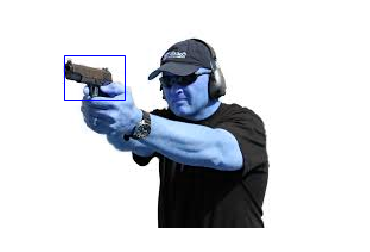

<Figure size 51840x51840 with 0 Axes>

In [80]:
import os
import xml.dom.minidom
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math
ImgPath = "/home/aistudio/VOC/JPEGImages/"
AnnoPath = "/home/aistudio/VOC/Annotations/" # xml文件地址

def draw_rectangle(currentAxis, bbox, edgecolor = 'k', facecolor = 'y', fill=False, linestyle='-'):
    # currentAxis，坐标轴，通过plt.gca()获取
    # bbox，边界框，包含四个数值的list， [x1, y1, x2, y2]
    # edgecolor，边框线条颜色
    # facecolor，填充颜色
    # fill, 是否填充
    # linestype，边框线型
    # patches.Rectangle需要传入左上角坐标、矩形区域的宽度、高度等参数
    rect=patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0]+1, bbox[3]-bbox[1]+1, linewidth=1,
                           edgecolor=edgecolor,facecolor=facecolor,fill=fill, linestyle=linestyle)
    currentAxis.add_patch(rect)

image_pre='260'
imgfile = ImgPath + image_pre + '.jpeg'
xmlfile = AnnoPath + image_pre + '.xml'

im = cv.imread(imgfile)
plt.imshow(im)

currentAxis=plt.gca()
# 打开xml文档
DOMTree = xml.dom.minidom.parse(xmlfile)
# 得到文档元素对象
collection = DOMTree.documentElement

filenamelist = collection.getElementsByTagName("filename")
filename = filenamelist[0].childNodes[0].data

# 得到标签名为object的信息
objectlist = collection.getElementsByTagName("object")

for objects in objectlist:
    # 每个object中得到子标签名为name的信息
    namelist = objects.getElementsByTagName('name')
    # 通过此语句得到具体的某个name的值
    objectname = namelist[0].childNodes[0].data
    #print(objectname)

    bndbox = objects.getElementsByTagName('bndbox')
    #print(bndbox)
    
    for box in bndbox:
        x1_list = box.getElementsByTagName('xmin')
        x1 = int(x1_list[0].childNodes[0].data)
        y1_list = box.getElementsByTagName('ymin')
        y1 = int(y1_list[0].childNodes[0].data)
        x2_list = box.getElementsByTagName('xmax')  
        x2 = int(x2_list[0].childNodes[0].data)
        y2_list = box.getElementsByTagName('ymax')
        y2 = int(y2_list[0].childNodes[0].data)
        bbox=[x1, y1, x2, y2]
        draw_rectangle(currentAxis, bbox, edgecolor = 'b')

plt.axis('off')  
plt.figure(figsize=(720, 720))      
plt.show()

In [ ]:
# 设置使用0号GPU卡
import matplotlib
matplotlib.use('Agg') 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import paddlex as pdx

# 2.2使用PaddleX划分数据集

In [ ]:
!paddlex --split_dataset --format VOC --dataset_dir VOC --val_value 0.2 --test_value 0.1 

# 2.3数据集配置与数据增强
定义数据处理流程，其中训练和测试需分别定义，训练过程包括了部分测试过程中不需要的数据增强操作，如在本示例中，训练过程使用了MixupImage、RandomDistort、RandomExpand、RandomCrop、RandomHorizontalFlip和BatchRandomResize共6种数据增强方式


In [ ]:
from paddlex import transforms as T
import paddlex as pdx
train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=-1), T.RandomDistort(),
    T.RandomExpand(im_padding_value=[123.675, 116.28, 103.53]), T.RandomCrop(),
    T.RandomHorizontalFlip(), T.BatchRandomResize(
        target_sizes=[
            320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640, 672, 704,
            736, 768
        ],
        interp='RANDOM'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = T.Compose([
    T.Resize(
        target_size=640, interp='CUBIC'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
#数据集加载
train_dataset = pdx.datasets.VOCDetection(
    data_dir='VOC',
    file_list='VOC/train_list.txt',
    label_list='VOC/labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir='VOC',
    file_list='VOC/val_list.txt',
    label_list='VOC/labels.txt',
    transforms=eval_transforms)

# 三、模型训练

# 3.1Faster RCNN算法简介
1. image input；
1. 利用selective search 算法在图像中从上到下提取2000个左右的建议窗口(Region Proposal)；
1. 将整张图片输入CNN，进行特征提取；
1. 把建议窗口映射到CNN的最后一层卷积feature map上；
1. 通过RoI pooling层使每个建议窗口生成固定尺寸的feature map；
1. 利用Softmax Loss(探测分类概率) 和Smooth L1 Loss(探测边框回归)对分类概率和边框回归(Bounding box regression)联合训练.
 

# 3.2配置超参数并训练模型
参数说明：

    train_dataset：训练数据集。
    num_epochs：训练轮次。
    train_batch_size：单次训练数据批次大小。
    learning_rate：学习率。



In [ ]:
num_classes = len(train_dataset.labels) + 1
model = pdx.det.FasterRCNN(num_classes=num_classes)
model.train(
    num_epochs=12,
    train_dataset=train_dataset,
    train_batch_size=2,
    eval_dataset=eval_dataset,
    learning_rate=0.0025,
    lr_decay_epochs=[8, 11],
    save_interval_epochs=1,
    save_dir='output/faster_rcnn_r50_fpn',
    use_vdl=True)

# 四、模型评估
效果一般，后期会进行优化

In [ ]:
model = pdx.load_model('output/faster_rcnn_r50_fpn/best_model')
model.evaluate(eval_dataset, batch_size=1, metric=None, return_details=False)

2022-02-16 20:08:50 [INFO]	Model[FasterRCNN] loaded.
2022-02-16 20:08:50 [INFO]	Start to evaluate(total_samples=66, total_steps=66)...
2022-02-16 20:08:53 [INFO]	Accumulating evaluatation results...


OrderedDict([('bbox_map', 46.72785909655489)])

# 五、可视化模型效果

2022-02-16 20:15:36 [INFO]	Model[FasterRCNN] loaded.


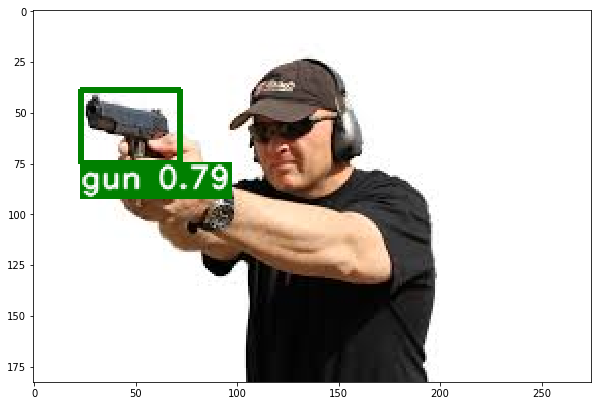

In [ ]:
import paddlex as pdx
from paddlex import transforms as T
import matplotlib.pyplot as plt

%matplotlib inline


eval_transforms = T.Compose([
    T.Resize(target_size=(1088, 1920), interp='CUBIC'), 
    T.Normalize(mean=[0.40158695, 0.43556893, 0.507324], std=[0.19307534, 0.19843009, 0.2915112])])

model = pdx.load_model('output/faster_rcnn_r50_fpn/best_model')
image_name =  'VOC/JPEGImages/260.jpeg'
result = model.predict(image_name)
pred = pdx.det.visualize(image_name, result, threshold=0.5, save_dir=None)
pred = pred[:, :, ::-1]  # 2RGB
plt.figure(figsize=(10, 10))
plt.imshow(pred)

# 作者简介
> 百度飞桨开发者技术专家 PPDE

> RHCE+RHCSA认证

> 渗透测试+SRC爱好者（贡献过一些CNVD）

> 微信公众号：DKsec（后期会更新啦！）
![](https://ai-studio-static-online.cdn.bcebos.com/27ddb5b3de45496a8e59249fcd911e68d79ef079b01349ea8256c3c05c855af3)


我在AI Studio上获得黄金等级，点亮4个徽章，来互关呀~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/314275